## Human Breast Cancer
**Date** : 2021-10-05<br>
**Author** : Alma Andersson<br>
**Description** : This notebook outlines the analysis related to the human breast cancer data.

In [1]:
%load_ext autoreload
%autoreload 2

import os.path as osp
import matplotlib.pyplot as plt
import anndata as ad
import eggplant as eg
import pandas as pd
import scanpy as sc
import numpy as np

In [18]:
SAVE_MODE = True

In [15]:
CNT_PTHS = ["../data/human-breast-cancer/curated/bcA.h5ad",
            "../data/human-breast-cancer/curated/bcB.h5ad"]

PROP_PTHS = ["../data/human-breast-cancer/sterescope/bcA.tsv",
             "../data/human-breast-cancer/sterescope/bcB.tsv"]

RES_DIR = "../../res/analysis/human-breast-cancer/"

In [3]:
adatas = [ad.read_h5ad(p) for p in CNT_PTHS]
props = [pd.read_csv(p,sep="\t",header = 0,index_col = 0) for p in PROP_PTHS]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
for k in range(len(adatas)):
    _tmp = props[k]
    _tmp.index  = adatas[k].obs.index
    _tmp.iloc[:,:] = (_tmp.values - _tmp.values.mean(axis=0)) / _tmp.values.std(axis=0)
    adatas[k].obsm["stereoscope"] = _tmp

adatas = {"bcA":adatas[0],"bcB":adatas[1]}

In [5]:
for a in adatas.values():
    sc.pp.filter_cells(a,min_counts=100)
    print(a)

/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/pandas-1.3.1-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial', 'stereoscope'


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 3986 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial', 'stereoscope'


In [6]:
ref = eg.m.Reference(adatas["bcA"].obsm["spatial"],
                    landmarks = adatas["bcA"].uns["curated_landmarks"],
                    )

In [7]:
eg.pp.match_scales(adatas["bcB"],ref)
eg.pp.get_landmark_distance(adatas["bcB"])


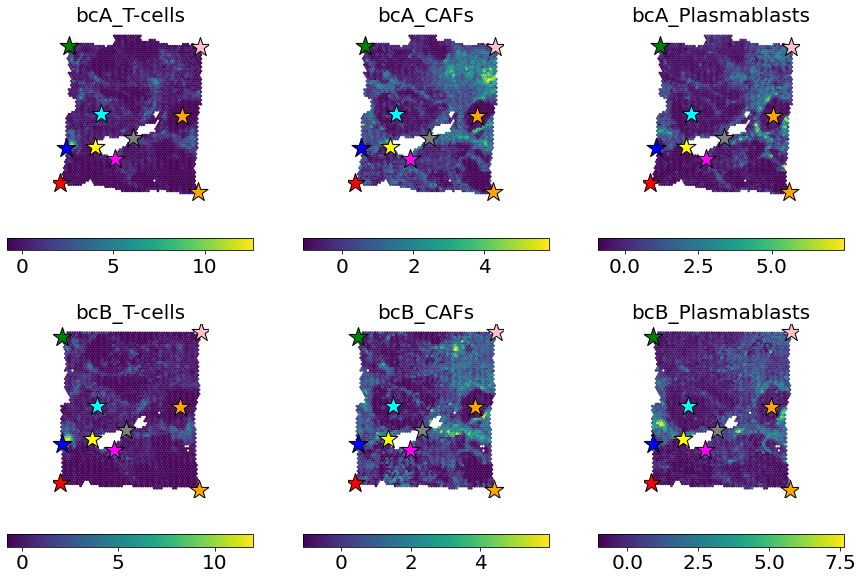

In [29]:
cell_types = ["T-cells","CAFs","Plasmablasts"]

fig,ax = eg.pl.visualize_observed(adatas,
                         features = cell_types,
                         n_cols = 3,
                         n_rows = 2,
                         flip_y = True,
                         include_title = True,
                         fontsize = 20,
                         marker_size =3,
                         share_colorscale = False,
                         separate_colorbar = False,
                         side_size = 5,
                         landmark_marker_size = 400,
                         show_landmarks = True,
                         colorbar_fontsize = 20,
                         return_figures = True,
                        )
if SAVE_MODE: fig.savefig(osp.join(RES_DIR,"human-breast-cancer-observed.png"),
                         bbox_inches ="tight")

In [10]:
np.random.seed(1337)
losses = eg.fun.transfer_to_reference(dict(bcB = adatas["bcB"]),
                                     cell_types,
                                     ref,
                                     n_epochs=1000,
                                     device ="gpu",
                                     verbose = True,
                                     return_losses = True,
                                     return_models =False,
                                     max_cg_iterations = 10000,
                                     )

[Processing] ::  Model : bcB | Feature : T-cells | Transfer : 1/3


/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/eggplant-0.1-py3.8.egg/eggplant/models.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ldists = t.tensor(landmark_distances)
/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/eggplant-0.1-py3.8.egg/eggplant/models.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = t.tensor(feature_values)
  0%|                                    | 0/1000 [00:00<?, ?it/s]/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/gpytorch-1.5.0-py3.8.egg/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [1

[Processing] ::  Model : bcB | Feature : CAFs | Transfer : 2/3


/home/alma.andersson/miniconda3/lib/python3.8/site-packages/anndata-0.7.5-py3.8.egg/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|█████████████████████████| 1000/1000 [00:36<00:00, 27.25it/s]


[Processing] ::  Model : bcB | Feature : Plasmablasts | Transfer : 3/3


100%|█████████████████████████| 1000/1000 [00:36<00:00, 27.53it/s]


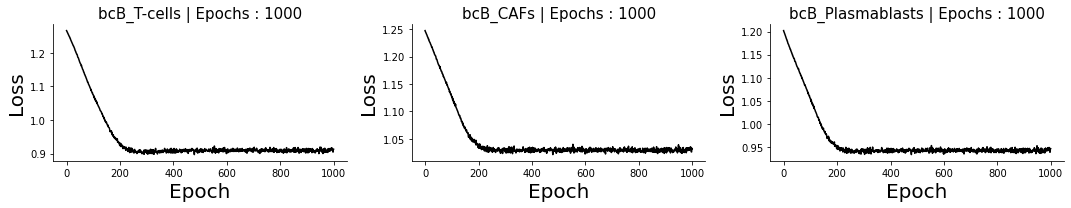

In [11]:
eg.pl.model_diagnostics(losses = losses)

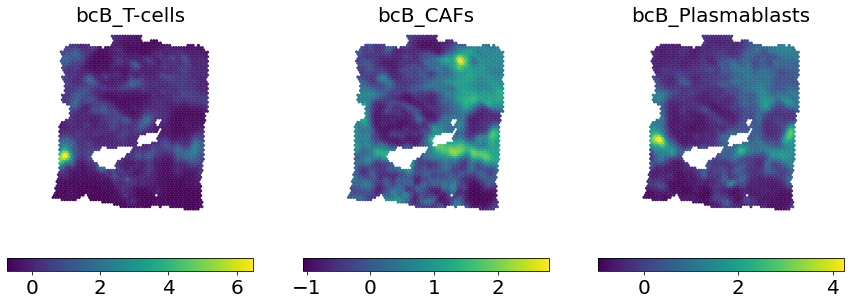

In [27]:
fig,ax = eg.pl.visualize_transfer(ref,
                                  n_cols = 3,
                                  side_size = 5,
                                  flip_y = True,
                                  quantile_scaling = False,
                                  show_landmarks = False,
                                  marker_size = 4,
                                  include_colorbar = True,
                                  separate_colorbar = False,
                                  share_colorscale = False,
                                  fontsize = 20,
                                  colorbar_fontsize = 20,
                                  hspace = 0.4,
                                  return_figures = True,
                                 )

if SAVE_MODE: fig.savefig(osp.join(RES_DIR,"human-breast-cancer-trans.png"),
                         bbox_inches = "tight",
                         )